# 7/2/2022
### YoloV5 TFlite model in Android studio
* To run it in android studio, we first have to create metadata for the tflite model

In [3]:
from tflite_support.metadata_writers import object_detector
from tflite_support.metadata_writers import writer_utils
from tflite_support import metadata
ObjectDetectorWriter = object_detector.MetadataWriter
_MODEL_PATH = r"C:\Users\aadia\Downloads\yolov5s-fp16.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "labels.txt"
_SAVE_TO_PATH = "yolo_with_metadata.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ObjectDetectorWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

C:\Users\aadia\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


{
  "name": "ObjectDetector",
  "description": "Identify which of a known set of objects might be present and provide information about their positions within the given image or a video stream.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be detected.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
     

C:\Users\aadia\anaconda3\lib\site-packages\tensorflow_lite_support\metadata\python\metadata.py:395: UserWarning: File, 'labels.txt', does not exist in the metadata. But packing it to tflite model is still allowed.
  warnings.warn(


* When trying to run this model, we get the following error:
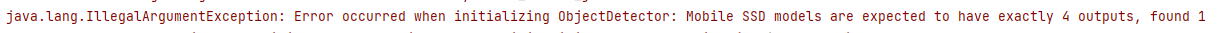
* This is because the model only gives one output for some reason and not the 4 outputs which explain the bounding boxes. Therefore, the TFlite model from LOOPR does not work in the app demo.

# 7/3/2022
#### Resources
* https://devblogs.microsoft.com/azure-sdk/ai-on-iot-edge/?adlt=strict&toWww=1&redig=961F027CF546482AB35BF115E035F0BB -guide
* https://pypi.org/project/jetson-emulator/ -emulator
* https://rawgit.com/dusty-nv/jetson-inference/dev/docs/html/python/jetson.html -emulator documentation

Jetson Nano Emulator:

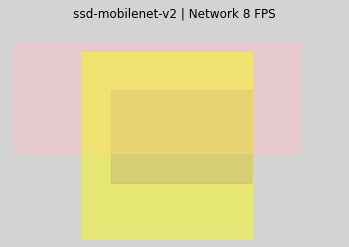

detected 3 objects in image

class_desc: bottle
<jetson.inference.Detection object>
   -- ClassID: 45
   -- Confidence: 0.592146
   -- Left: 1195.0
   -- Top: 668.0
   -- Right: 2804.0
   -- Bottom: 1593.0
   -- Width: 1609.0
   -- Height: 925.0
   -- Area: 1488325.0
   -- Center: (1999.5, 1130.5)

class_desc: desk
<jetson.inference.Detection object>
   -- ClassID: 70
   -- Confidence: 0.584934
   -- Left: 64.0
   -- Top: 197.0
   -- Right: 3361.0
   -- Bottom: 1294.0
   -- Width: 3297.0
   -- Height: 1097.0
   -- Area: 3616809.0
   -- Center: (1712.5, 745.5)

class_desc: pizza
<jetson.inference.Detection object>
   -- ClassID: 60
   -- Confidence: 0.982439
   -- Left: 843.0
   -- Top: 296.0
   -- Right: 2808.0
   -- Bottom: 2160.0
   -- Width: 1965.0
   -- Height: 1864.0
   -- Area: 3662760.0
   -- Center: (1825.5, 1228.0)

detectNet,random,03,45,1195,2804,668,1593,70,64,3361,197,1294,60,843,2808,296,2160,.jpg


In [120]:
#Importing libraries
import jetson_emulator.inference as inference
import jetson_emulator.utils as utils

network = "ssd-mobilenet-v2"     # Defines the neural network being used for inference


net = inference.detectNet(network, threshold=0.5)   # Creates the detectNet object used in inference, taking the network and
                                                    # prediction threshold as input
    
input_URI = "rtsp://jetson_emulator:554/detectNet/random_cam/4k" # Defines a string which represents the input resource path.
                                                                 # In this case, the resource path is to a real time stream of
                                                                 # random images
input = utils.videoSource(input_URI, argv="")
output = utils.videoOutput("display://1", argv="")
img = input.Capture()
detections = net.Detect(img, "box")
output.SetStatus("{:s} | Network {:.0f} FPS".format(network, net.GetNetworkFPS()))
output.Render(img)

print("detected {:d} objects in image\n".format(len(detections)) )
for detection in detections:
    print("class_desc:", net.GetClassDesc(detection.ClassID))  
    print(detection)
    
print(img.cudaMemory)

NOTE: This entire process is all bogus and random number generation - there isn't any actual image detection going on, all the info is pre-generated with randint. You need an actual Jetson Nano to be able to run the actual inference

# 7/6/2022
### Detectron 2 instance segmentation w/ COCO data
_https://gilberttanner.com/blog/detectron2-train-a-instance-segmentation-model/_

1. First, gather COCO Json image data. Once that is done, simply run a command to register the COCO data as follows:

In [1]:
# Import packages
import os
import numpy as np
import json
import random
import cv2

from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import ColorMode

ModuleNotFoundError: No module named 'torch'

In [2]:
# Create one instance of registration for testing and another for training
for d in ["Train", "Test"]:
    register_coco_instances(f"instance_segment_{d}_7-6-22", {}, f"COCO Data/{d}_Coco.json", "COCO Data/Images")

In [3]:
# Visualize images and annotations:

dataset_dicts = DatasetCatalog.get("instance_segment_Train_7-6-22") # Get a list of dictionaries, each one representing an
                                                                    #      annotated image.
    
for d in random.sample(dataset_dicts, 3):                           # Iterate through a list of three random images.
    img = cv2.imread(d["file_name"])                                # Read in the image using the file name provided
    visualizer = Visualizer(img[:, :, ::-1], scale=0.5)             # Get a visualizer of the annotations with detectron2
    vis = visualizer.draw_dataset_dict(d)                           # Draw annotations from the dictionary
    cv2.imshow('image', vis.get_image()[:, :, ::-1])                # Display the annotated immage
    cv2.waitKey(0)                                                  # Waits for a key entry to proceed


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



2. Now that we've registered the dataset, we can train the model. We get the cfg file and use a prebuilt instance segmentation model from the model zoo as a starting point:

In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("COCO Data/Images",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

AssertionError: Torch not compiled with CUDA enabled

### NOTE: We are getting a CUDA error because we are using an Intel graphics card - CUDA only works with NVIDIA graphics cards sadly, and Detectron2 only works with CUDA-enabled torch.

### Instead, we will do this through a Google CoLab: https://colab.research.google.com/drive/1riH_3PCjPjZniR6eokGE5cXHJ1s6g-tP#scrollTo=UtMZx9KZuMNk

# 7/8/2022
### YOLOv5 tutorial
_Following this tutorial: https://www.youtube.com/watch?v=x0ThXHbtqCQ_<br>
_Code is running in the following Google CoLab: https://colab.research.google.com/drive/1Tl0Vtp1cvzn77a4v-c6hfzkqfWL9F0RP#scrollTo=ZbUn4_b9GCKO_
_Roboflow stuff is at https://app.roboflow.com/micasheets/blister-detection/3_

1. First, we clone YOLOv5 using Git, and install dependencies as well as some necessary packages.
2. Use app.roboflow.com and use the free community tool convert annotated COCO Json data into the proper format usable by YOLOv5 (https://roboflow.com/convert/coco-json-to-yolov5-pytorch-txt) - note that you have to upload a folder containing 3 subfolders - train, test, and valid. Train must contain all training images and the training COCO Json file, as with test.
3. Run some code to get the annotated data into CoLab using OS and Roboflow
4. Train the model by running the train.py file, giving inputs such as image size, batch size, epoch number, and starting weights.
5. Run inference by running the detect.py file, giving inputs such as threshold, image path, and image size
6. Display inference results by entering folder where they are located and displaying them.